Import module/Set up XS path/Create openMC model/Clean directory

In [207]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import pandas as pd
from IPython.display import Image
import glob

%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
model=openmc.Model()

clean_file_list = ["model.xml", "materials.xml", "geometry.xml","plots.xml","geometry.xml","settings.xml","tallies.out","summary.h5","statepoint.50.h5"]

for file in clean_file_list :
    path_file = os.path.join(os.getcwd(), file)
    if os.path.exists(path_file):
        os.remove(path_file)

env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml


Define Materials

In [208]:
uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)
zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)
helium=openmc.Material(name='helium')
helium.add_element('helium',1)
helium.set_density('g/cm3',8e-4)
water = openmc.Material(name="water")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

    
model.materials = openmc.Materials([uo2, zirconium, water,helium]) 
model.materials.export_to_xml()

Create pincell_in

In [209]:
fuel_outer_radius = openmc.ZCylinder(r=0.39)
gap_outer_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)
pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')
    
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -gap_outer_radius
clad_region = +gap_outer_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius
    
fuel_in = openmc.Cell(name='fuel_in')
fuel_in.fill = uo2
fuel_in.region = fuel_region
gap_in = openmc.Cell(name='gap_in')
gap_in.fill=helium
gap_in.region = gap_region
clad_in = openmc.Cell(name='clad_in')
clad_in.fill = zirconium
clad_in.region = clad_region
moderator_in = openmc.Cell(name='moderator_in')
moderator_in.fill = water
moderator_in.region = water_region

u_in = openmc.Universe(cells=(fuel_in, gap_in, clad_in, moderator_in))

Create pincell_out

In [210]:
fuel_out = openmc.Cell(name='fuel_out')
fuel_out.fill = uo2
fuel_out.region = fuel_region
gap_out = openmc.Cell(name='gap_out')
gap_out.fill=helium
gap_out.region = gap_region
clad_out = openmc.Cell(name='clad_out')
clad_out.fill = zirconium
clad_out.region = clad_region
moderator_out = openmc.Cell(name='moderator_out')
moderator_out.fill = water
moderator_out.region = water_region
    
u_out = openmc.Universe(cells=(fuel_out, gap_out, clad_out, moderator_out))

Define assembly

In [211]:
   assembly = openmc.RectLattice()
assembly.lower_left = (-1.5*pitch, -1.5*pitch)
assembly.pitch = (1.26, 1.26)
assembly.universes = [[u_out, u_out, u_out],
                      [u_out, u_in, u_out],
                      [u_out, u_out, u_out]]
            
    
    
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

min_x = openmc.XPlane(x0=0., boundary_type='reflective')
max_x = openmc.XPlane(x0=+1.5*pitch, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0., boundary_type='reflective')
max_y = openmc.YPlane(y0=+1.5*pitch, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z
    
    
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)
model.geometry = openmc.Geometry(root_universe)
model.geometry.export_to_xml()


/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another UniverseBase instance already exists with id=0.
  warn(msg, IDWarning)


Plot assembly

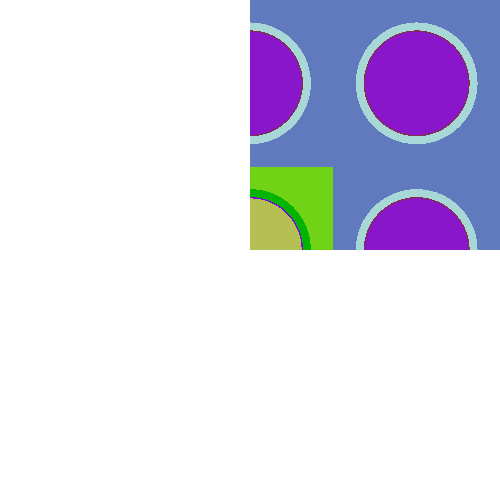

In [212]:
plot = openmc.Plot.from_geometry(model.geometry)
plot.pixels = (500, 500)
plot.width = (3*pitch, 3*pitch)
plot.origin = (0., 0., 0)
plot.color_by = 'cell'
# plot.colors = {
#     water: 'blue',
#     zirconium: 'black',
#     helium: 'yellow',
#     uo2_in: (100, 0, 0),
#     uo2_out: (255, 0, 0)
# }
plot.to_ipython_image()

Choose settings

In [213]:
source = openmc.IndependentSource()
source.space = openmc.stats.Point((0.1,0.1,0.))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([10.0e6], [1.0])
source.time = openmc.stats.Uniform(0, 1e-6)
settings = openmc.Settings()
settings.source = source
settings = openmc.Settings()
settings.source = source
settings.batches = 50
settings.inactive = 10
settings.particles = 1000
settings.output = {'tallies':True}
model.settings = settings
model.settings.export_to_xml()

Create MGXS tallies

In [214]:
VIMS69=np.array([1e-11, 5e-09, 1e-08, 1.5e-08, 2e-08, 2.5e-08, 3e-08, 3.5e-08, 4.2e-08, 5e-08, 5.8e-08, 6.7e-08, 8e-08, 1e-07, 1.4e-07, 1.8e-07, 2.2e-07, 2.5e-07, 2.8e-07, 3e-07, 3.2e-07, 3.5e-07, 4e-07, 5e-07, 6.25e-07, 7.8e-07, 8.5e-07, 9.1e-07, 9.5e-07, 9.72e-07, 9.96e-07, 1.02e-06, 1.045e-06, 1.071e-06, 1.097e-06, 1.123e-06, 1.15e-06, 1.3e-06, 1.5e-06, 2.1e-06, 2.6e-06, 3.3e-06, 4e-06, 9.877e-06, 1.5968e-05, 2.77e-05, 4.8052e-05, 7.55014e-05, 0.000148729, 0.000367263, 0.000906899, 0.0014251, 0.00223945, 0.0035191, 0.00553, 0.009118, 0.01503, 0.02478, 0.04085, 0.06734, 0.111, 0.183, 0.3025, 0.5, 0.821, 1.353, 2.231, 3.679, 6.0655, 10.0])

XMAS172=np.array([1.00001e-11, 3e-09, 5e-09, 6.9e-09, 1e-08, 1.5e-08, 2e-08, 2.5e-08, 3e-08, 3.5e-08, 4.2e-08, 5e-08, 5.8e-08, 6.7e-08, 7.7e-08, 8e-08, 9.5e-08, 1e-07, 1.15e-07, 1.34e-07, 1.4e-07, 1.6e-07, 1.8e-07, 1.89e-07, 2.2e-07, 2.48e-07, 2.8e-07, 3e-07, 3.145e-07, 3.2e-07, 3.5e-07, 3.91e-07, 4e-07, 4.33e-07, 4.85e-07, 5e-07, 5.4e-07, 6.25e-07, 7.05e-07, 7.8e-07, 7.9e-07, 8.5e-07, 8.6e-07, 9.1e-07, 9.3e-07, 9.5e-07, 9.72e-07, 9.86e-07, 9.96e-07, 1.02e-06, 1.035e-06, 1.045e-06, 1.071e-06, 1.097e-06, 1.11e-06, 1.123e-06, 1.15e-06, 1.17e-06, 1.235e-06, 1.3e-06, 1.3375e-06, 1.37e-06, 1.44e-06, 1.475e-06, 1.5e-06, 1.59e-06, 1.67e-06, 1.755e-06, 1.84e-06, 1.93e-06, 2.02e-06, 2.1e-06, 2.13e-06, 2.36e-06, 2.55e-06, 2.6e-06, 2.72e-06, 2.76792e-06, 3.3e-06, 3.38075e-06, 4e-06, 4.12925e-06, 5.043477e-06, 5.34643e-06, 6.160116e-06, 7.523983e-06, 8.315287e-06, 9.189814e-06, 9.905554e-06, 1.122446e-05, 1.370959e-05, 1.592827e-05, 1.945484e-05, 2.260329e-05, 2.49805e-05, 2.760773e-05, 3.051126e-05, 3.372015e-05, 3.726653e-05, 4.0169e-05, 4.551744e-05, 4.82516e-05, 5.157802e-05, 5.559513e-05, 6.790405e-05, 7.567357e-05, 9.166088e-05, 0.000136742, 0.0001486254, 0.000203995, 0.0003043248, 0.0003717032, 0.0004539993, 0.0006772874, 0.0007485183, 0.0009142423, 0.001010394, 0.001234098, 0.001433817, 0.001507331, 0.002034684, 0.002248673, 0.003354626, 0.003526622, 0.005004514, 0.005530844, 0.007465858, 0.00911882, 0.01113775, 0.01503439, 0.01661557, 0.02478752, 0.02739445, 0.029283, 0.03697864, 0.04086771, 0.05516564, 0.06737947, 0.08229747, 0.11109, 0.1227734, 0.1831564, 0.2472353, 0.2732372, 0.3019738, 0.407622, 0.450492, 0.4978707, 0.5502322, 0.6081006, 0.82085, 0.9071795, 1.002588, 1.108032, 1.224564, 1.353353, 1.652989, 2.018965, 2.231302, 2.46597, 3.011942, 3.678794, 4.49329, 5.488116, 6.065307, 6.7032, 8.187308, 10.0, 11.618343, 13.840307, 14.918247, 17.33253, 19.64033])

choose_group=XMAS172
name_group='XMAS172'
groups = mgxs.EnergyGroups(group_edges = choose_group)

openmc_cell=model.geometry.get_all_cells().values()


In [215]:
xs_library = {}
for cell in openmc_cell:
	xs_library[cell.id] = {}
	xs_library[cell.id]['transport']  = mgxs.TransportXS(energy_groups=groups)
	xs_library[cell.id]['fission'] = mgxs.FissionXS(energy_groups=groups)
	xs_library[cell.id]['nu-fission'] = mgxs.FissionXS(energy_groups=groups, nu=True)
	xs_library[cell.id]['nu-scatter'] = mgxs.ScatterMatrixXS(energy_groups=groups, nu=True)
	xs_library[cell.id]['chi'] = mgxs.Chi(energy_groups=groups)

In [216]:
tally_trigger = openmc.Trigger('std_dev', 1e-2)
for cell in openmc_cell:
    for mgxs_type in xs_library[cell.id]:
        xs_library[cell.id][mgxs_type].tally_trigger = tally_trigger
        

tallies = openmc.Tallies()   
for cell in openmc_cell:
    for rxn_type in xs_library[cell.id]:
        xs_library[cell.id][rxn_type].domain = cell
        xs_library[cell.id][rxn_type].by_nuclide = False
        for tally in xs_library[cell.id][rxn_type].tallies.values():
            tallies.append(tally, merge=True)
                   
model.tallies = tallies

In [217]:
model.export_to_xml()

sp_file = model.run()
sp = openmc.StatePoint(sp_file)

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=888.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=670.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=671.
  warn(msg, IDWarning)
/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=672.
  warn(msg, IDWarning)


[Machine2:78991] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%

In [218]:
if not os.path.exists("mgxs"):
    os.makedirs("mgxs")

df_energy = pd.DataFrame(choose_group)
df_energy[1] = str(name_group)
csv_file_path = os.path.join("mgxs", "energy_groups.csv")
df_energy.to_csv(csv_file_path, index=False)

for cell in openmc_cell:
    for rxn_type in xs_library[cell.id]:
        xs_library[cell.id][rxn_type].load_from_statepoint(sp)
        A=xs_library[cell.id][str(rxn_type)]
        A_xs=A.get_xs()
        dict_name=str(rxn_type) + '_' + str(cell.name) +'_'+ 'mgxs'
        df=A.get_pandas_dataframe(xs_type='macro') 
        csv_file_path = os.path.join("mgxs", dict_name + ".csv")
        df.to_csv(csv_file_path, index=False)


